# Boundary Membrane Generation Code

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from math import floor, sqrt


boundary_membrane_pts = None         # Nx2 array of (x,y)
initial_edge_length = None           # N-element array
level_set_phi = None                 # grid: shape (Nx, Ny)
ls_xmin = None
a_xmin = None  # typo guard
ls_ymin = None
grid_x = None
grid_y = None
ls_dx = None
ls_dy = None

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_boundary_shape(a,b,amp,freq,num_points):

    pts = np.array([]).reshape(0, 3) 

    # Generating points for a deformed ellipse like shape
    for i in range(num_points):
        theta = 2.0 * np.pi * i / num_points
        r_x = a * (1.0 + amp * np.cos(freq * theta))
        r_y = b * (1.0 + amp * np.sin(freq * theta))
        x = r_x * np.cos(theta)
        y = r_y * np.sin(theta)

        pts = np.vstack((pts, [x, y, 0.0]))
    return pts

[]


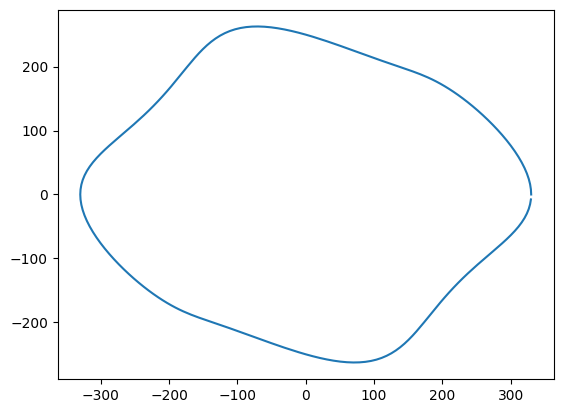

In [11]:
# Example usage
a=300
b=250
amp = .1
freq =4

boundary_pts=generate_boundary_shape(a,b,amp,freq,num_points=200)
plt.plot(boundary_pts[:,0], boundary_pts[:,1])

_____________
# Reintialize Code

In [ ]:
def is_inside(x, y, BM_pts):  # This uses numpys ray-casting algorithm
    path = Path(BM_pts)
    return path.contains_point((x, y))

def rebuild_signed_distance_field(boundary_pts, grid_x, grid_y): 
    global level_set_phi
    Nx = len(grid_x)
    Ny = len(grid_y)
    phi = np.zeros((Nx, Ny))
    Np = boundary_membrane_pts.shape[0]
    # segments
    starts = boundary_membrane_pts
    ends = np.roll(boundary_membrane_pts, -1, axis=0)


    seg_start = boundary_pts
    seg_end = np.roll(boundary_pts,-1, axis=0)

    Nx, Ny = len(grid_x), len(grid_y)
    Np = len(boundary_pts)

    phi = np.zeros((Nx,Ny))

    # Meshgrid of points
    X, Y = np.meshgrid(grid_x, grid_y, indexing='ij')
    pts = np.stack([X.ravel(), Y.ravel()]).T

    # Compute minimum distance to any segment for all points
    dists = np.full(pts.shape[0], np.inf)
    for p1, p2 in zip(seg_start, seg_end)

    




_______


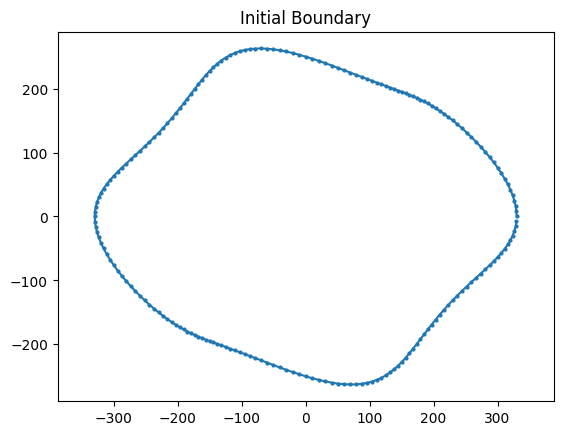

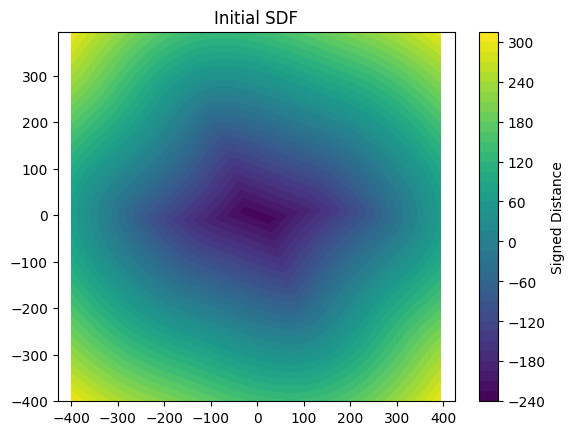

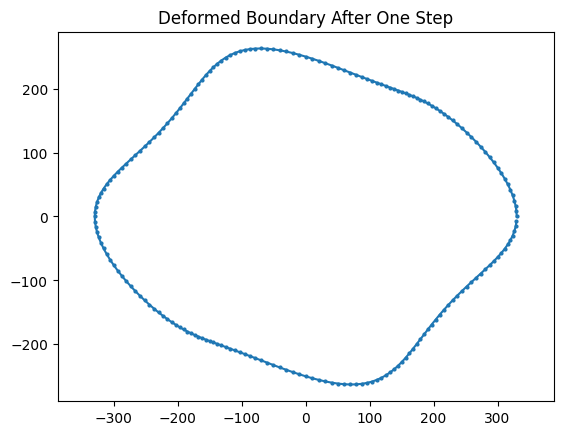

In [ ]:
# Jupyter Notebook: Independent Testing of Basement Membrane Deformation

# 1. Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


# 2. Generate Initial Boundary Shape

def generate_boundary_shape(a, b, amp, freq, num_points):
    """
    Generate deformed ellipse boundary points.
    Returns an (N,2) array of x,y coordinates.
    """
    thetas = np.linspace(0, 2*np.pi, num_points, endpoint=False)
    r_x = a * (1 + amp * np.cos(freq * thetas))
    r_y = b * (1 + amp * np.sin(freq * thetas))
    x = r_x * np.cos(thetas)
    y = r_y * np.sin(thetas)
    return np.vstack([x, y]).T

# Example usage
a, b = 300.0, 250.0
amp, freq, num_pts = 0.1, 4, 200
boundary_pts = generate_boundary_shape(a, b, amp, freq, num_pts)
plt.plot(boundary_pts[:,0], boundary_pts[:,1], '-o', markersize=2)
plt.axis('equal')
plt.title('Initial Boundary')
plt.show()

## 3. Point-In-Polygon Test
from matplotlib.path import Path

def is_inside(x, y, boundary_pts):
    """Winding number / ray casting via matplotlib.Path."""
    path = Path(boundary_pts)
    return path.contains_point((x, y))

## 4. Build Signed Distance Field (SDF)
def rebuild_signed_distance_field(boundary_pts, grid_x, grid_y):
    """
    Compute signed distance on a mesh defined by grid_x, grid_y.
    grid_x, grid_y: 1D arrays of x and y coordinates respectively.
    Returns phi: shape (len(grid_x), len(grid_y)).
    """
    # Precompute segments
    seg_start = boundary_pts
    seg_end = np.roll(boundary_pts, -1, axis=0)

    # Prepare phi
    Nx, Ny = len(grid_x), len(grid_y)
    phi = np.zeros((Nx, Ny))

    # Meshgrid of points
    X, Y = np.meshgrid(grid_x, grid_y, indexing='ij')
    pts = np.stack([X.ravel(), Y.ravel()]).T

    # Compute minimum distance to any segment for all points
    dists = np.full(pts.shape[0], np.inf)
    for p1, p2 in zip(seg_start, seg_end):
        # projection mechanics
        v = p2 - p1
        w = pts - p1
        v2 = np.dot(v, v)
        t = np.clip(np.dot(w, v) / v2 if v2>0 else 0, 0, 1)
        proj = p1 + t[:,None] * v
        dist_seg = np.linalg.norm(pts - proj, axis=1)
        dists = np.minimum(dists, dist_seg)

    # Determine sign
    signs = np.array([ -1 if is_inside(x,y,boundary_pts) else 1
                       for x,y in pts ])
    phi_flat = signs * dists
    return phi_flat.reshape(Nx, Ny)

# Example grid
ls_dx = ls_dy = 5.0
grid_x = np.arange(-400, 400, ls_dx)
grid_y = np.arange(-400, 400, ls_dy)
phi = rebuild_signed_distance_field(boundary_pts, grid_x, grid_y)

# Visualize SDF
plt.contourf(grid_x, grid_y, phi.T, levels=50)
plt.colorbar(label='Signed Distance')
plt.axis('equal')
plt.title('Initial SDF')
plt.show()

## 5. Compute Cell Force
def level_set_gradient(phi, i, j, dx, dy):
    Nx, Ny = phi.shape
    # central differences
    phi_x = ((phi[min(i+1,Nx-1),j] - phi[max(i-1,0),j])/(2*dx)
             if 0<i<Nx-1 else
             (phi[i+1,j]-phi[i,j])/dx if i==0 else (phi[i,j]-phi[i-1,j])/dx)
    phi_y = ((phi[i,j+1] - phi[i,j-1])/(2*dy)
             if 0<j<Ny-1 else
             (phi[i,j+1]-phi[i,j])/dy if j==0 else (phi[i,j]-phi[i,j-1])/dy)
    return np.array([phi_x, phi_y])

def compute_cell_force(pos, phi, grid_x, grid_y, dx, dy,
                       d0=5.0, strength=1e-3):
    # map position to indices
    i = int(np.clip((pos[0]-grid_x[0])/dx, 0, phi.shape[0]-1))
    j = int(np.clip((pos[1]-grid_y[0])/dy, 0, phi.shape[1]-1))
    d = phi[i,j]
    if abs(d) <= d0:
        return np.zeros(2)
    grad = level_set_gradient(phi, i, j, dx, dy)
    normal = grad / np.linalg.norm(grad) if np.linalg.norm(grad)>0 else grad
    sign = 1 if d<0 else -1
    mag = strength * abs(d - d0)
    return sign * mag * normal

# Update Deformation Step
def update_basement_membrane_deformation(boundary_pts, phi,
                                        grid_x, grid_y, dx, dy,
                                        cell_positions, dt,
                                        strength=1e-3):
    Np = boundary_pts.shape[0]
    node_forces = np.zeros((Np,2))
    # Compute forces
    for pos in cell_positions:
        f = compute_cell_force(pos, phi, grid_x, grid_y, dx, dy,
                               strength=strength)
        # find closest segment
        seg_starts = boundary_pts
        seg_ends = np.roll(boundary_pts, -1, axis=0)
        # compute projection distances
        # ... (similar logic to C++)
        # accumulate node_forces
    # Update positions
    boundary_pts += node_forces * dt
    # Rebuild phi
    phi = rebuild_signed_distance_field(boundary_pts, grid_x, grid_y)
    return boundary_pts, phi


_______
# Testing

In [ ]:

## 7. Testing Framework
# Sample random cell positions
cell_positions = np.random.uniform(low=-350, high=350, size=(50,2))
dt = 0.1

# Run one deformation step
t, phi = update_basement_membrane_deformation(
    boundary_pts.copy(), phi, grid_x, grid_y, ls_dx, ls_dy,
    cell_positions, dt)

# Plot updated boundary
plt.plot(boundary_pts[:,0], boundary_pts[:,1], '-o', markersize=2)
plt.title('Deformed Boundary After One Step')
plt.axis('equal')
plt.show()
